<a href="https://colab.research.google.com/github/shamshegab/Airbnb-recruiting-competition-/blob/master/Airbnb-recruiting-competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Colormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ndcg_score
from sklearn.svm import SVC
import sklearn
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.naive_bayes import GaussianNB
from sklearn import tree



In [0]:
#read train, test and session data, and merge train with session
def read_data():
  data_set=pd.read_csv("drive/My Drive/Airbnb data/train_users_2.csv")
  test_set=pd.read_csv("drive/My Drive/Airbnb data/test_users.csv")
  session=pd.read_csv("drive/My Drive/Airbnb data/sessions.csv")

  df = session.groupby('user_id')['action'].nunique()
  df=df.rename("action_unique")
  data_set=pd.merge(data_set, df, left_on='id', right_on='user_id', how='left')
  data_set.action_unique=data_set.action_unique.fillna(0)

  df = session.groupby('user_id')['action'].count()
  df=df.rename("action_count")
  data_set=pd.merge(data_set, df, left_on='id', right_on='user_id', how='left')
  data_set.action_count=data_set.action_count.fillna(0) 

  df = session.groupby('user_id')['action'].nunique()
  df=df.rename("action_unique")
  test_set=pd.merge(test_set, df, left_on='id', right_on='user_id', how='left')
  test_set.action_unique=test_set.action_unique.fillna(0)
  
  df = session.groupby('user_id')['action'].count()
  df=df.rename("action_count")
  test_set=pd.merge(test_set, df, left_on='id', right_on='user_id', how='left')
  test_set.action_count=test_set.action_count.fillna(0) 

  data_set=data_set.drop(['id'], axis = 1)
  testIDs=test_set.id.values
  test_set=test_set.drop(['id'], axis = 1)

  return data_set,test_set



In [0]:
#split labels & feuture engineering
def clean_data(data_set):
  labels=data_set.country_destination.values
  data_set=data_set.drop(['country_destination'], axis = 1)
  for i in range (len(data_set)):
    if(data_set.age[i]>1900):
      data_set.age[i]=2016-data_set.age[i]
    if(data_set.gender[i]=='-unknown-'):
      data_set.gender[i]='OTHER'

  data_set.date_first_booking=data_set.date_first_booking.fillna('0000-00-00')
  data_set=data_set.fillna(-1)
  data_set=handle_dates(data_set)

  catigories = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
             'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
  for i in catigories:
    dummy = pd.get_dummies(data_set[i], prefix=i)
    data_set = data_set.drop([i], axis=1)
    data_set = pd.concat((data_set, dummy), axis=1)
  return data_set,labels


In [0]:
#visualizing the data for analysis
def visualize(data_set):
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
  complete_age = data_set[data_set.age.notnull()].country_destination.value_counts()
  missing_age = data_set[data_set.age.isnull()].country_destination.value_counts()
  complete_age.div(complete_age.sum()).plot(kind='bar',title='Country Destination Proportion (Age completed)',ax=axes[0])
  missing_age.div(missing_age.sum()).plot(kind='bar',title='Country Destination Proportion (Age missing)',ax=axes[1])

  fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 4))
  country_counts = data_set.country_destination.value_counts()
  ax = country_counts.div(country_counts.sum()).plot(kind='bar',title='Country Destination %' )
  ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()])

  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
  sns.barplot(x='country_destination', y='action_count', data=data_set, ax =ax)
  ax.set_ylim([10, 60])


 
  cat_vars = ['gender', 'signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider', 
            'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'language']
  fig, ax4 = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
  for i,var in enumerate(cat_vars[:8]):
    pltCatVar(var,ax4,i,data_set)
  plt.tight_layout()
  fig, ax5 = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), sharey=True)
  for i,var in enumerate(cat_vars[8:]):
    pltCatVar(var,ax5,i,data_set)
  box = ax5[0].get_position()
  ax5[0].set_position([box.x0, box.y0 + box.height * 0.4, box.width, box.height * 0.6])
  ax5[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=6)


def pltCatVar(var,axis,ax_num,data_set):
    bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
    ctab = pd.crosstab([data_set[var]], data_set.country_destination).apply(lambda x: x/x.sum(), axis=1)
    ctab[bar_order].plot(kind='bar', stacked=True, ax=axis.reshape(-1)[ax_num],legend=False, 
                         colormap='terrain')


In [0]:
def OHE(labels):
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(labels)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  labels = onehot_encoder.fit_transform(integer_encoded)
  return labels


In [0]:
def handle_dates(data_set):
  dac = np.vstack(data_set.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
  data_set['dac_year'] = dac[:,0]
  data_set['dac_month'] = dac[:,1]
  data_set['dac_day'] = dac[:,2]
  data_set = data_set.drop(['date_account_created'], axis=1)
#timestamp_first_active

  tfa = np.vstack(data_set.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
  data_set['tfa_year'] = tfa[:,0]
  data_set['tfa_month'] = tfa[:,1]
  data_set['tfa_day'] = tfa[:,2]
  data_set = data_set.drop(['timestamp_first_active'], axis=1)


  dfb = np.vstack(data_set.date_first_booking.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
  data_set['dfb_year'] = dfb[:,0]
  data_set['dfb_month'] = dfb[:,1]
  data_set['dfb_day'] = dfb[:,2]
  data_set = data_set.drop(['date_first_booking'], axis=1)
  return data_set


In [0]:
def KNearestneighbor(X_train, X_test, y_train, y_test):
  neigh = KNeighborsClassifier(n_neighbors=500)
  neigh.fit(X_train, y_train)
  y_pred=neigh.predict(X_test.values)
  ndgcScore=ndcg_score(y_test,y_pred,k=5)
  print("KNN accuracy = ",accuracy_score(y_test, y_pred))
  print("KNN NDGC = ",ndgcScore)

In [0]:
def DT(X_train, X_test, y_train, y_test):
  dt = tree.DecisionTreeClassifier()
  dt = dt.fit(X_train, y_train)
  y_pred = dt.predict(X_test)
  ndgcScore=ndcg_score(y_test,y_pred,k=5)
  print("Decision trees accuracy = ",accuracy_score(y_test, y_pred))
  print("Decision trees NDGC = ",ndgcScore)


In [0]:
def CNN(X_train, X_test, y_train, y_test,weights):

  model = Sequential()
  model.add(Dense(64, input_dim=159, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu')) 
  model.add(Dense(32, activation='relu'))
  model.add(Dense(12, activation='softmax'))
  model.summary()
  model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
 

  filepath="weights-simple.hdf5"
  checkpointer = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
  history = model.fit(X_train,y_train, batch_size=64 , verbose=1, validation_split=0.20, 
          shuffle=True, epochs=10,callbacks=[checkpointer],class_weight=weights)
  model.load_weights("weights-simple.hdf5")
  _, accuracy = model.evaluate(X_test, y_test)

  ndgcScore=ndcg_score(y_test,model.predict(X_test.values),k=5)

  print("CNN accu = ",accuracy)
  print("CNN NDGC = ",ndgcScore)

In [11]:
data_set,test_data=read_data()
print(data_set.shape,test_data.shape)


(213451, 17) (62096, 16)


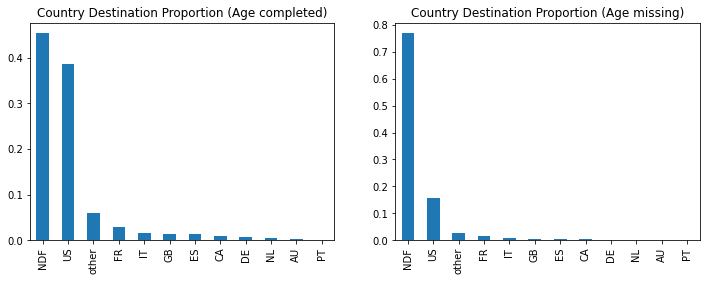

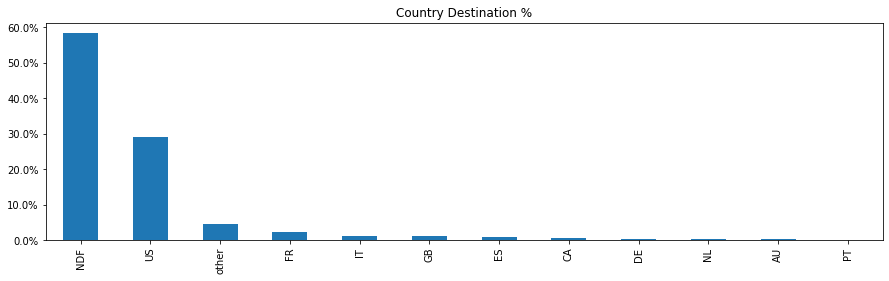

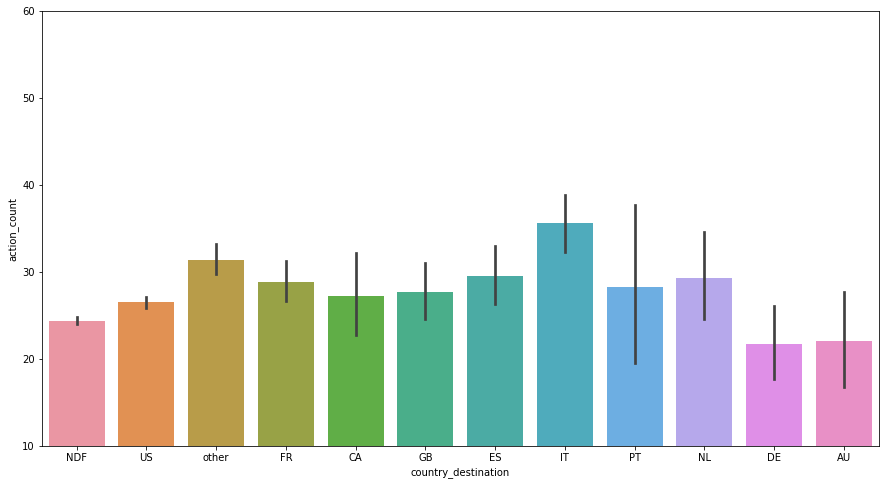

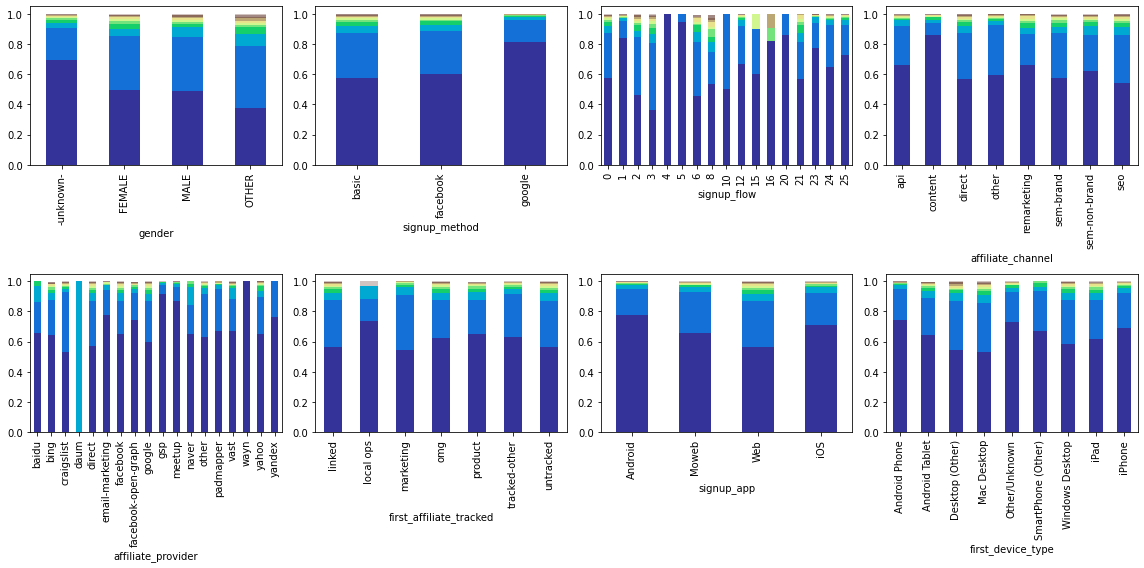

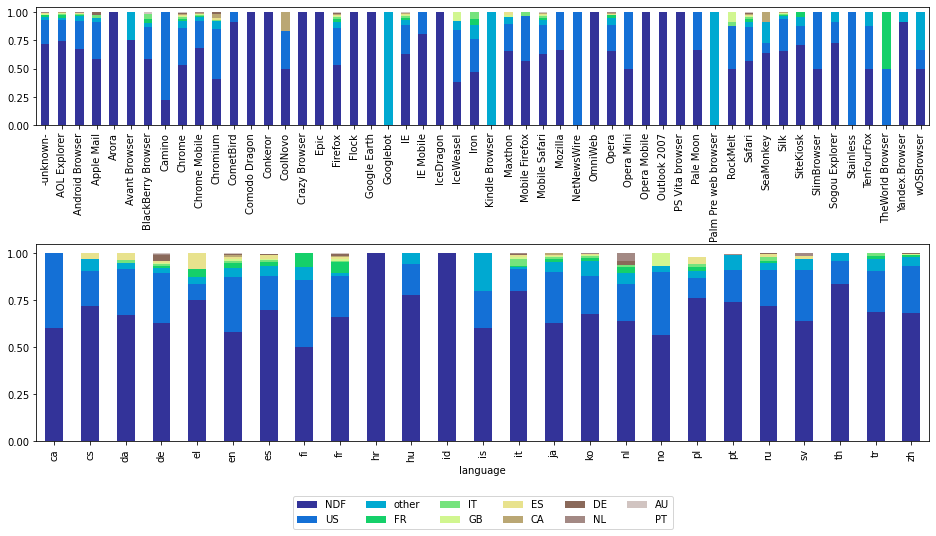

In [22]:
visualize(data_set)

In [40]:
training_set,labels=clean_data(data_set)
labels_encoded=OHE(labels)
X_train, X_test, y_train, y_test = train_test_split(training_set, labels_encoded, test_size=0.2)
weights=sklearn.utils.class_weight.compute_class_weight('balanced',np.unique(labels),labels)
CNN(X_train, X_test, y_train, y_test,weights)
KNearestneighbor(X_train, X_test, y_train, y_test)
DT(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                10240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 12)                396       
Total params: 13,772
Trainable params: 13,772
Non-trainable params: 0
_________________________________________________________________
Train on 136608 samples, validate on 34152 samples
Epoch 1/10
136608/136608 [==============================] - 11s 8